In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import urllib.request
import json
import os
import re
from tqdm import tqdm
import math
import time

# Setup device
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

torch.set_printoptions(sci_mode=False)


Using device: mps


# GPT-2 from Scratch: Implementation and Fine-tuning

In [2]:
# Download and load the text corpus
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)

with open(file_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f"Total number of characters: {len(raw_text)}")
print(raw_text[:100])


Total number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [3]:
# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Demonstrate tokenization
encoded_text = tokenizer.encode(raw_text)
print(f"\nTotal number of tokens: {len(encoded_text)}")
print("Sample encoded tokens:", encoded_text[:15])



Total number of tokens: 5145
Sample encoded tokens: [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016]


## Building the GPT Model Architecture


In [4]:
# Layer Normalization
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [5]:
# GELU Activation Function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


In [6]:
# Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    def forward(self, x):
        return self.layers(x)


In [7]:
# Multi-Head Causal Self-Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        
        # Apply causal mask
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        # Scale and apply softmax
        attn_weights = torch.softmax(attn_scores / math.sqrt(self.head_dim), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        # Reshape and project output
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec


In [8]:
# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add input

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add input
        return x


In [9]:
# Full GPT Model
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_ids = torch.arange(seq_len, device=in_idx.device)
        pos_embeds = self.pos_emb(pos_ids)
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


## Loading Pretrained GPT-2 Weights


In [10]:
# Model and Text Generation Configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


In [11]:
# Utility functions for text generation
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0)

def token_ids_to_text(token_ids, tokenizer):
    return tokenizer.decode(token_ids.squeeze(0).tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [12]:
# Download and load GPT-2 weights
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch05/"
       "01_main-chapter-code/gpt_download.py")
filename = "gpt_download.py"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

from gpt_download import download_and_load_gpt2

model_size = "124M"
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

# Tweak config to match pretrained model
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
}
model_name = f"gpt2-small ({model_size})"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [13]:
# Function to load weights into our model
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)
        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [14]:
# Instantiate and test the loaded model
import numpy as np

torch.manual_seed(123)
model = GPTModel(NEW_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval()

prompt = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer).to(device),
    max_new_tokens=15,
    context_size=NEW_CONFIG["context_length"]
)
print("Model Output:")
print(token_ids_to_text(token_ids, tokenizer))


Model Output:
Every effort moves you forward.

The first step is to understand the importance of your work


## Fine-Tuning for Spam Classification with LoRA


In [15]:
# Preparing the Spam Dataset
import urllib.request
import zipfile
import os
from pathlib import Path

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    print("Downloading spam dataset...")
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")
    os.remove(zip_path)

# Set up paths and URLs
primary_url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
backup_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# Execute the download with error handling
try:
    download_and_unzip_spam_data(primary_url, zip_path, extracted_path, data_file_path)
except Exception as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    download_and_unzip_spam_data(backup_url, zip_path, extracted_path, data_file_path)

# Load, process, and split the data
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# Create a balanced dataset
num_spam = df[df["Label"] == "spam"].shape[0]
ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# Split and save datasets
train_frac, val_frac = 0.7, 0.1
df_shuffled = balanced_df.sample(frac=1, random_state=123).reset_index(drop=True)
train_end = int(len(df_shuffled) * train_frac)
val_end = train_end + int(len(df_shuffled) * val_frac)
train_df, val_df, test_df = df_shuffled[:train_end], df_shuffled[train_end:val_end], df_shuffled[val_end:]

train_df.to_csv("train.csv", index=None)
val_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

print("\nSample of training data:")
print(train_df.head())


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.

Sample of training data:
   Label                                               Text
0      0                Dude how do you like the buff wind.
1      0  Tessy..pls do me a favor. Pls convey my birthd...
2      1  Reminder: You have not downloaded the content ...
3      1  Got what it takes 2 take part in the WRC Rally...
4      1  Shop till u Drop, IS IT YOU, either 10K, 5K, £...


In [16]:
# Creating a Custom Dataset and DataLoaders
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        self.encoded_texts = [encoded[:self.max_length] for encoded in self.encoded_texts]
        self.encoded_texts = [encoded + [pad_token_id] * (self.max_length - len(encoded)) for encoded in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(encoded) for encoded in self.encoded_texts)

# Initialize datasets and dataloaders
train_dataset = SpamDataset(csv_file="train.csv", tokenizer=tokenizer)
val_dataset = SpamDataset(csv_file="validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file="test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)


### Implementing LoRA Layers


In [17]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        return self.alpha * (x @ self.A @ self.B)

class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x):
        return self.linear(x) + self.lora(x)

def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # Do not replace the final classification head
            if name != "out_head":
                setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)


In [18]:
# Modifying the Model for Classification and Applying LoRA
# Re-load a fresh pretrained model
torch.manual_seed(123)
model_lora = GPTModel(NEW_CONFIG)
load_weights_into_gpt(model_lora, params)

# Add a classification head
num_classes = 2
model_lora.out_head = torch.nn.Linear(in_features=NEW_CONFIG["emb_dim"], out_features=num_classes)

# Freeze original model parameters
for param in model_lora.parameters():
    param.requires_grad = False
    
# Apply LoRA and unfreeze LoRA and classification head parameters
lora_rank = 8
lora_alpha = 16
replace_linear_with_lora(model_lora, rank=lora_rank, alpha=lora_alpha)

# Unfreeze the new layers
for param in model_lora.out_head.parameters():
    param.requires_grad = True
for name, param in model_lora.named_parameters():
    if "lora" in name:
        param.requires_grad = True

# Move the ENTIRE modified model to the device at the end
model_lora.to(device)
        
total_trainable_params = sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
print(f"Total trainable parameters with LoRA: {total_trainable_params:,}")


Total trainable parameters with LoRA: 1,328,642


### Training the LoRA-adapted Model


In [19]:
# Utility functions for classification training
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Use last token's output for classification
    return torch.nn.functional.cross_entropy(logits, target_batch)

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
    return correct_predictions / num_examples

def evaluate_model_cls(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = np.mean([calc_loss_batch(X, y, model, device).item() for i, (X, y) in enumerate(train_loader) if i < eval_iter])
        val_loss = np.mean([calc_loss_batch(X, y, model, device).item() for i, (X, y) in enumerate(val_loader) if i < eval_iter])
    model.train()
    return train_loss, val_loss

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model_cls(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | Validation accuracy: {val_accuracy*100:.2f}%")
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [20]:
# Run the training
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model_lora.parameters(), lr=5e-5, weight_decay=0.01)
num_epochs = 3

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model_lora, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=20, eval_iter=5
)


Ep 1 (Step 000000): Train loss 2.028, Val loss 1.822
Ep 1 (Step 000020): Train loss 0.573, Val loss 0.592
Ep 1 (Step 000040): Train loss 0.358, Val loss 0.549
Ep 1 (Step 000060): Train loss 0.315, Val loss 0.386
Ep 1 (Step 000080): Train loss 0.623, Val loss 0.506
Ep 1 (Step 000100): Train loss 0.348, Val loss 0.493
Ep 1 (Step 000120): Train loss 0.152, Val loss 0.396
Training accuracy: 97.50% | Validation accuracy: 87.50%
Ep 2 (Step 000140): Train loss 0.555, Val loss 0.688
Ep 2 (Step 000160): Train loss 0.240, Val loss 0.578
Ep 2 (Step 000180): Train loss 0.204, Val loss 0.218
Ep 2 (Step 000200): Train loss 0.164, Val loss 0.247
Ep 2 (Step 000220): Train loss 0.070, Val loss 0.261
Ep 2 (Step 000240): Train loss 0.279, Val loss 0.556
Training accuracy: 90.00% | Validation accuracy: 87.50%
Ep 3 (Step 000260): Train loss 0.152, Val loss 0.228
Ep 3 (Step 000280): Train loss 0.132, Val loss 0.126
Ep 3 (Step 000300): Train loss 0.198, Val loss 0.234
Ep 3 (Step 000320): Train loss 0.073, Va

### Evaluating the Fine-Tuned Classifier


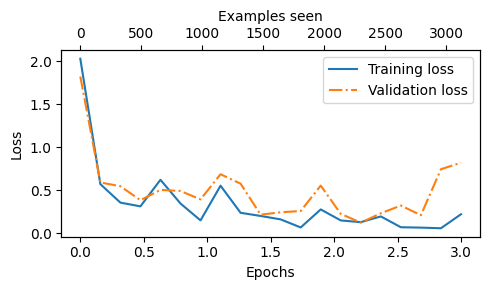

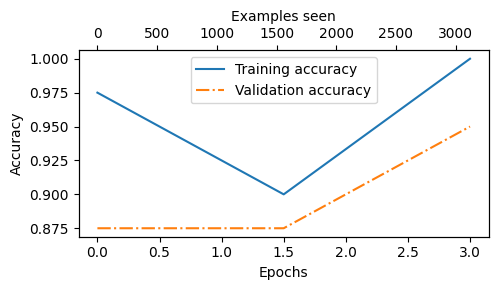

In [21]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")


In [22]:
# Final evaluation on the test set
test_accuracy = calc_accuracy_loader(test_loader, model_lora, device)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# Example classification
def classify_review(text, model, tokenizer, device, max_length, pad_token_id=50256):
    model.eval()
    encoded = tokenizer.encode(text)
    encoded = encoded[:max_length]
    encoded += [pad_token_id] * (max_length - len(encoded))
    input_tensor = torch.tensor(encoded, device=device).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"

text_1 = "You are a winner you have been specially selected to receive $1000 cash or a $2000 award."
text_2 = "Hey, just wanted to check if we're still on for dinner tonight? Let me know!"

print(f"'{text_1}' is classified as: {classify_review(text_1, model_lora, tokenizer, device, train_dataset.max_length)}")
print(f"'{text_2}' is classified as: {classify_review(text_2, model_lora, tokenizer, device, train_dataset.max_length)}")


Test accuracy: 96.33%
'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' is classified as: spam
'Hey, just wanted to check if we're still on for dinner tonight? Let me know!' is classified as: not spam


## Instruction Fine-Tuning


In [23]:
# Preparing the Instruction Dataset
file_path = "instruction-data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
       "main/ch07/01_main-chapter-code/instruction-data.json")
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)

with open(file_path, "r") as file:
    instruction_data = json.load(file)

# Split the data
train_portion = int(len(instruction_data) * 0.85)
test_portion = int(len(instruction_data) * 0.1)
train_data_instr = instruction_data[:train_portion]
test_data_instr = instruction_data[train_portion : train_portion + test_portion]
val_data_instr = instruction_data[train_portion + test_portion :]

# Prompt formatting function
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

print("Sample formatted prompt:")
print(format_input(instruction_data[50]))


Sample formatted prompt:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


### Custom Data Handling for Instruction Tuning


In [24]:
# Instruction Dataset and Custom Collate Function
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100):
    # Find the length of the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)
    
    inputs_lst, targets_lst = [], []

    for item in batch:
        # Create a new list with an added padding token at the end
        new_item = item.copy()
        new_item.append(pad_token_id)
        
        # Pad the new item to the max length of the batch
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        # Mask out the padding tokens in the targets
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst)
    targets_tensor = torch.stack(targets_lst)
    return inputs_tensor, targets_tensor


In [25]:
# Creating DataLoaders
from functools import partial

customized_collate_fn = partial(custom_collate_fn)

train_dataset_instr = InstructionDataset(train_data_instr, tokenizer)
train_loader_instr = DataLoader(
    train_dataset_instr, batch_size=4, collate_fn=customized_collate_fn, shuffle=True, drop_last=True
)
val_dataset_instr = InstructionDataset(val_data_instr, tokenizer)
val_loader_instr = DataLoader(
    val_dataset_instr, batch_size=4, collate_fn=customized_collate_fn, shuffle=False
)
test_dataset_instr = InstructionDataset(test_data_instr, tokenizer)
test_loader_instr = DataLoader(
    test_dataset_instr, batch_size=4, collate_fn=customized_collate_fn, shuffle=False
)


### Fine-Tuning the GPT-2 Medium Model


In [26]:
# Load GPT-2 Medium (355M)
model_size_medium = "355M"
settings_medium, params_medium = download_and_load_gpt2(model_size=model_size_medium, models_dir="gpt2")

model_configs_medium = {"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16}}
CHOOSE_MODEL_MEDIUM = "gpt2-medium (355M)"
BASE_CONFIG_MEDIUM = GPT_CONFIG_124M.copy() # Start with base and update
BASE_CONFIG_MEDIUM.update(model_configs_medium[CHOOSE_MODEL_MEDIUM])
BASE_CONFIG_MEDIUM.update({"context_length": 1024, "qkv_bias": True})

model_instr = GPTModel(BASE_CONFIG_MEDIUM)
load_weights_into_gpt(model_instr, params_medium)
model_instr.to(device)


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [27]:
# Training and Loss Functions for Language Modeling
def calc_loss_batch_language_modeling(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)), 
        target_batch.view(-1)
    )
    return loss

def calc_loss_loader_instr(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break
            loss = calc_loss_batch_language_modeling(input_batch, target_batch, model, device)
            total_loss += loss.item()
    return total_loss / num_batches

def train_model_simple_instr(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, tokenizer):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        for i, (input_batch, target_batch) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            optimizer.zero_grad()
            loss = calc_loss_batch_language_modeling(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            # Evaluation
            if i > 0 and i % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = calc_loss_loader_instr(train_loader, model, device, num_batches=eval_iter)
                    val_loss = calc_loss_loader_instr(val_loader, model, device, num_batches=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1}, Step {i}: Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}")
                model.train()
    return train_losses, val_losses


In [28]:
# Run instruction fine-tuning
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model_instr.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2 # Using 2 epochs for demonstration

train_losses, val_losses = train_model_simple_instr(
    model_instr, train_loader_instr, val_loader_instr, optimizer, device,
    num_epochs=num_epochs, eval_freq=100, eval_iter=10, tokenizer=tokenizer
)

# Save the fine-tuned model
torch.save(model_instr.state_dict(), "gpt2-medium-sft.pth")


Epoch 1:  43%|████▎     | 101/233 [00:50<01:59,  1.11it/s]

Epoch 1, Step 100: Train Loss 0.598, Val Loss 0.788


Epoch 1:  86%|████████▋ | 201/233 [01:29<00:24,  1.30it/s]

Epoch 1, Step 200: Train Loss 0.594, Val Loss 0.679


Epoch 2:  43%|████▎     | 101/233 [00:41<01:50,  1.19it/s]

Epoch 2, Step 100: Train Loss 0.393, Val Loss 0.671


Epoch 2:  86%|████████▋ | 201/233 [01:22<00:26,  1.23it/s]

Epoch 2, Step 200: Train Loss 0.361, Val Loss 0.658


Epoch 2: 100%|██████████| 233/233 [01:34<00:00,  2.46it/s]


## Evaluating with LLM-as-a-Judge


In [29]:
# Generate responses for the test set
model_instr.eval()
test_data_with_responses = test_data_instr.copy()

# Advanced text generation function with temperature and top-k
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(-1)
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
        
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            
        if eos_id is not None and idx_next.item() == eos_id:
            break
            
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

for i, entry in tqdm(enumerate(test_data_with_responses), total=len(test_data_with_responses)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model_instr,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG_MEDIUM["context_length"],
        eos_id=50256 # <|endoftext|>
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    test_data_with_responses[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as f:
    json.dump(test_data_with_responses, f, indent=4)
    
print("\nGenerated response for the first test sample:")
print(test_data_with_responses[0])


100%|██████████| 110/110 [02:04<00:00,  1.14s/it]


Generated response for the first test sample:
{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


### Scoring Responses with Llama 3 via Ollama


In [30]:
import psutil

# Check if Ollama is running
def check_if_running(process_name):
    return any(process_name in proc.info["name"] for proc in psutil.process_iter(["name"]))

if not check_if_running("ollama"):
    print("Ollama is not running. Please start it to proceed with evaluation.")
else:
    print("Ollama is running.")

def query_model(prompt, model="llama3", url="http://localhost:11434/api/generate"):
    data = {
        "model": model,
        "prompt": prompt,
        "stream": False,
        "options": {"seed": 123, "temperature": 0}
    }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")
    
    with urllib.request.urlopen(request) as response:
        response_data = json.loads(response.read().decode("utf-8"))
        return response_data.get("response", "").strip()

# Function to automate scoring
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the instruction `{entry['instruction']}` and input `{entry['input']}`, "
            f"and the correct output `{entry['output']}`, "
            f"score the model's generated response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is a perfect response. "
            f"Respond with only the integer score."
        )
        score_str = query_model(prompt, model)
        try:
            score = int(re.search(r'\d+', score_str).group()) # Extract first number
            scores.append(score)
        except (ValueError, AttributeError):
            print(f"Could not parse score from response: '{score_str}'")
            continue
    return scores

# Run the evaluation if Ollama is active
if check_if_running("ollama"):
    scores = generate_model_scores(test_data_with_responses, "model_response")
    if scores:
        print(f"\nNumber of scores collected: {len(scores)} of {len(test_data_with_responses)}")
        print(f"Average score: {sum(scores)/len(scores):.2f}")
else:
    print("Skipping evaluation as Ollama is not running.")


Ollama is running.


Scoring entries: 100%|██████████| 110/110 [00:53<00:00,  2.06it/s]


Number of scores collected: 110 of 110
Average score: 43.05
